# Time-warped PCA demo

This notebook demonstrates the application of time-warped PCA to a synthetic dataset to recover the underlying latent dynamics and trial alignment. The dataset consists of a one dimensional latent state with three events that occur over the course of each trial. The exact time of each event is jittered from trial-to-trial which makes averaging across trials distort the underlying dynamics.

## Setup

In [1]:
%pylab inline
np.random.seed(1234)
from scipy.ndimage.filters import convolve1d, gaussian_filter1d
from twpca import TWPCA
from twpca.regularizers import curvature
import itertools as itr
import seaborn as sns
sns.set_style("ticks")

Populating the interactive namespace from numpy and matplotlib


## Dataset options

In [2]:
n_time = 130
n_trial = 100
n_neuron = 50

tau = 10 # time constant for exponential decay of latent events
event_gap = 25 # average gap between events
n_events = 3 # number of events
max_jitter = 15 # maximum jitter of each event

## Generate synthetic data

In [3]:
# Randomly generate jitters
jitters = np.random.randint(-max_jitter, max_jitter, size=(n_trial, n_events))
ordering = np.argsort(jitters[:, 0])
jitters = jitters[ordering]

# Create one-hot matrix that encodes the location of latent events
events = np.zeros((n_trial, n_time))
for trial_idx, jitter in enumerate(jitters):
    trial_event_times = np.cumsum(event_gap + jitter)
    events[trial_idx, trial_event_times] = 1.0
avg_event = np.zeros(n_time)
avg_event[np.cumsum([event_gap] * n_events)] = 1.0

# Convolve latent events with an exponential filter
impulse_response = np.exp(-np.arange(n_time)/float(tau))
impulse_response /= impulse_response.sum()

latents = np.array([np.convolve(e, impulse_response, mode='full')[:n_time] for e in events])
avg_latent = np.convolve(avg_event, impulse_response, mode='full')[:n_time]

# Coupling from one dimensional latent state to each neuron
readout_weights = np.random.rand(n_neuron) + 0.1

# Probability of firing for each neuron
rates = np.exp(np.array([np.outer(latent, readout_weights) for latent in latents]))
rates -= rates.min()#(0, 1), keepdims=True)
rates /= rates.max()#0,1), keepdims=True)

# Sample spike trains
spikes = np.random.binomial(1, rates).astype(np.float32)

In [4]:
# Mark end of last few trials as missing data to demonstrate that twPCA works with variable-length data
spikes[80:, 115:] = np.nan

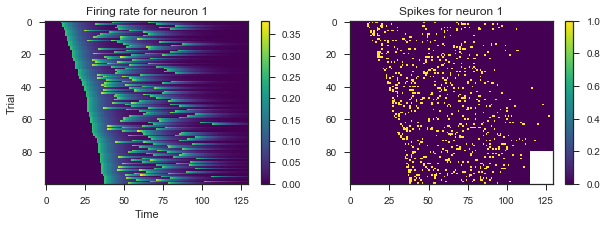

In [5]:
figure(figsize=(10,3))
subplot(121)
imshow(rates[..., 0], aspect='auto', cmap=cm.viridis); colorbar()
title('Firing rate for neuron 1')
xlabel('Time')
ylabel('Trial')
subplot(122)
imshow(spikes[..., 0], aspect='auto', cmap=cm.viridis); colorbar()
title('Spikes for neuron 1')

## twPCA options

In [ ]:
n_components = 1
smooth_std = 1.0

warp_penalty_strength = 0.05
time_penalty_strength = 0.5

## Construct and fit twPCA model

In [ ]:
# Smooth spike trains
smoothed_spikes = gaussian_filter1d(spikes, smooth_std, axis=1)

# Add an L1 penalty on the second order finite difference of the warping functions
# This encourages the warping functions to be piecewise linear.
warp_regularizer = curvature(scale=warp_penalty_strength, power=1)
# Adds an L2 penatly on the second order finite difference of the temporal factors.
# Encourages the temporal factors to be smooth in time.
time_regularizer = curvature(scale=time_penalty_strength, power=2, axis=0)

model = TWPCA(n_components,
              warp_regularizer=warp_regularizer,
              time_regularizer=time_regularizer,
              fit_trial_factors=False,
              nonneg=True,
              warpinit='shift')
# Fit model with gradient descent, starting with a learning rate of 1e-1 for 250 iterations,
# and then a learning rate of 1e-2 for 500 iterations
model.fit(smoothed_spikes, lr=(1e-1, 1e-2), niter=(500, 3000))
# Extract model parameters and reconstruction of the data (X_pred)
params = model.params
X_pred = model._sess.run(model.X_pred)

 76%|███████▌  | 2273/3000 [00:59<00:18, 39.06it/s]

### Visualize learned warping functions

In [ ]:
plot(params['warp'].T, alpha=0.2);
axis('square')
xlabel('Clock time')
ylabel('Aligned time')
xlim(0, 100);
ylim(0, 100)
title('Learned warping functions')

# twPCA accurately recovers latent dynamics

In [ ]:
u,s,v = np.linalg.svd(np.nanmean(spikes, axis=0), full_matrices=False)
pca_trial_recon = s[0]*np.outer(u[:,0], v[0])
s = np.sign(np.sum(u[:,0]))
s *= np.linalg.norm(avg_latent)/np.linalg.norm(u[:,0])
pca_time_factor = s*u[:,0]

plot(avg_latent, '-k', lw=5, alpha=0.7, label='True')    
plot(pca_time_factor, '-b', lw=4, alpha=0.7, label='PCA')
time_fctr = params['time']
s = np.sign(np.sum(time_fctr))
s *= np.linalg.norm(avg_latent.ravel())/np.linalg.norm(time_fctr.ravel())
plot(s*time_fctr, '-r', alpha=0.7, lw=4, label='twPCA')
    #ax.set_title('warp={0:.2f}, time={1:.2f}'.format(warp_reg, time_reg))

plt.tight_layout()
legend(loc='upper right',fontsize=24, bbox_to_anchor=(1.2, 0.8))#, fontsize=24)
xticks([])
yticks([])
xlabel('Time', fontsize=24)
ylabel('a.u.', fontsize=24)
sns.despine()
xlim(10, 110)

# twPCA learns better reconstructions of the data

In [ ]:
u,s,v = np.linalg.svd(np.nanmean(smoothed_spikes, axis=0), full_matrices=False)

figure(figsize=(16, 7))
gs = GridSpec(3, 4)

im_kwargs = dict(cmap='hot', aspect='auto', interpolation='none')
for i, tidx in enumerate([0, n_trial//2, -1]):
    for j, x in enumerate((rates, smoothed_spikes, X_pred)):
        subplot(gs[i, j])

        if i == 0:
            title(['Latent dynamics', 'Spikes', 'twPCA recon'][j], fontsize=28)
        imshow(x[tidx].T, **im_kwargs)
        if not (i == 2 and j == 0):
            gca().set_xticklabels([])
            gca().set_yticklabels([])
        else:
            xlabel('Time')
            ylabel('Neuron')
            
    subplot(gs[i, -1]);
    imshow(pca_trial_recon.T, **im_kwargs)
    gca().set_xticklabels([]); gca().set_yticklabels([]);
    if i == 0:
        title('PCA recon', fontsize=28)